In [190]:
import tensorflow as tf 
from tensorflow import keras
import os 
import numpy as np 
import matplotlib.pyplot as plt
import segmentation_models as sm
from glob import glob
import cv2


In [194]:
# base_path = 'D:/Dropbox/2. WORK/SNUH/Atopy Segmentation'
base_path = 'C:/Users/user/Desktop/Atopy Segmentation'
# path_8 = os.path.join(base_path, 'Intersect_0.8')
paths = ['Intersect_0.75', 'Intersect_0.8', 'Intersect_0.85']
path = 'Intersect_0.75'
grades = ['Grade0', 'Grade1', 'Grade2', 'Grade3']

In [220]:
x_train = {}
y_train = {}

x_test = {}
y_test = {}

x_extra = {}
y_extra = {} 


# for path in paths:  
for grade in grades:
    x_train_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Train', f'{grade}/*.jpg'))
    y_train_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Train', f'{grade}/*.png'))

    x_test_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Test', f'{grade}/*.jpg'))
    y_test_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Test', f'{grade}/*.png'))

    x_extra_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Extra', f'{grade}/*.jpg'))
    y_extra_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Extra', f'{grade}/*.png'))
    
    x_train[grade] = x_train_list
    y_train[grade] = y_train_list
    
    x_test[grade] = x_test_list
    y_test[grade] = y_test_list
    
    x_extra[grade] = x_extra_list
    y_extra[grade] = y_extra_list
    
# len(x_train), len(y_train)
len(x_train['Grade0']), len(x_test['Grade0']), len(x_extra['Grade0'])
    

(107, 33, 4)

In [221]:
N_RES = 256 
train_images = [] 
train_labels = [] 
none_mask = 0 
none_data = 0 

for x in x_train['Grade0']:
    img = cv2.imread(x, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    # img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = np.float64(img)
    
    y = x[:-4] + '.png'
    
    lbl = cv2.imread(y, cv2.COLOR_BGR2GRAY)
    # lbl = cv2.imread(y, 1)
    
    if lbl is None:
        print(f'Not found mask file : {x}') 
        none_mask += 1
        continue
    
    # if (lbl == 0).sum() < 1:
    #     # print(f'Not found something : {x}')
    #     none_data += 1
    #     continue
    
    lbl = cv2.resize(lbl, (N_RES, N_RES))
    # lbl = cv2.normalize(lbl, None, 0, 255, cv2.NORM_MINMAX)
    # lbl = np.float64(lbl)
    lbl = lbl.astype('float')
    
    train_images.append(img) 
    train_labels.append(lbl) 
    # 
train_images = np.reshape(train_images, [-1, N_RES, N_RES, 3])
train_labels = np.reshape(train_labels, [-1, N_RES, N_RES, 1])

none_mask, none_data
    

Not found mask file : C:/Users/user/Desktop/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade0\0968.jpg
Not found mask file : C:/Users/user/Desktop/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade0\1359.jpg
Not found mask file : C:/Users/user/Desktop/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade0\1550.jpg
Not found mask file : C:/Users/user/Desktop/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade0\1626.jpg
Not found mask file : C:/Users/user/Desktop/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade0\1902.jpg
Not found mask file : C:/Users/user/Desktop/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade0\2818.jpg


(6, 0)

In [222]:
test_images = [] 
test_labels = [] 
none_mask = 0 
none_data = 0 

for x in x_test['Grade0']:
    img = cv2.imread(x, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = np.float32(img)
    
    y = x[:-4] + '.png'
    
    lbl = cv2.imread(y, cv2.COLOR_BGR2GRAY)
    # lbl = cv2.imread(y, 1)
    
    if lbl is None:
        print(f'Not found mask file : {x}') 
        none_mask += 1
        continue
        
    # if (lbl == 0).sum() < 1:
    #     # print(f'Not found something : {x}')
    #     none_data += 1 
    #     continue
    
    lbl = cv2.resize(lbl, (N_RES, N_RES))
    # lbl = cv2.normalize(lbl, None, 0, 255, cv2.NORM_MINMAX)
    # lbl = np.float32(lbl)
    lbl = lbl.astype('float')
    
    test_images.append(img) 
    test_labels.append(lbl) 
    
test_images = np.reshape(test_images, [-1, N_RES, N_RES, 3])
test_labels = np.reshape(test_labels, [-1, N_RES, N_RES, 1])

none_mask, none_data

Not found mask file : C:/Users/user/Desktop/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Test\Grade0\7034.jpg
Not found mask file : C:/Users/user/Desktop/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Test\Grade0\7106.jpg
Not found mask file : C:/Users/user/Desktop/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Test\Grade0\8063.jpg


(3, 0)

In [223]:
BACKBONE = 'efficientnetb4'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [224]:
# preprocess input
train_images = preprocess_input(train_images)
# x_val = preprocess_input(x_val)


In [225]:
test_images = preprocess_input(test_images)

In [226]:
train_images.shape, train_labels.shape

((101, 256, 256, 3), (101, 256, 256, 1))

In [227]:
# model = sm.Unet('efficientnetb4', input_shape=(N_RES, N_RES, 3), classes=1, activation='sigmoid', encoder_weights='imagenet')
model = sm.Unet('efficientnetb4', input_shape=(N_RES, N_RES, 3), classes=1, activation='sigmoid', encoder_weights=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


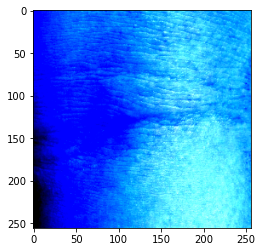

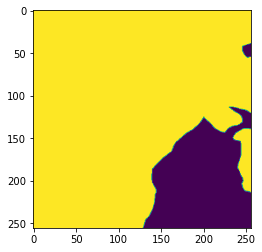

In [228]:
plt.imshow(train_images[19])
plt.show() 

plt.imshow(train_labels[19] )
plt.show() 


In [229]:
# define model
# model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,
            #  'accuracy',
            #  'val_accuracy'
             ],
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
hist = model.fit(x=train_images,
                 y=train_labels,
                 batch_size=16,
                 epochs=100,
                 validation_split=0.3,
                #    validation_data=(x_val, y_val),   
                )

Epoch 1/100
5/5 [==============================] - 16s 1s/step - loss: -51.8082 - iou_score: 1.2596 - val_loss: -24.9911 - val_iou_score: 1.1130
Epoch 2/100
5/5 [==============================] - 2s 313ms/step - loss: -173.6365 - iou_score: 2.0578 - val_loss: -115.3200 - val_iou_score: 1.6420
Epoch 3/100
5/5 [==============================] - 1s 296ms/step - loss: -266.1619 - iou_score: 3.0242 - val_loss: -995.7072 - val_iou_score: 22.2681
Epoch 4/100
5/5 [==============================] - 1s 296ms/step - loss: -342.8282 - iou_score: 4.0183 - val_loss: -939.5324 - val_iou_score: 21.2281
Epoch 5/100
5/5 [==============================] - 1s 291ms/step - loss: -413.0389 - iou_score: 5.2914 - val_loss: -1125.5510 - val_iou_score: 28.5613
Epoch 6/100
5/5 [==============================] - 1s 294ms/step - loss: -483.3578 - iou_score: 6.8114 - val_loss: -47582.8438 - val_iou_score: 91.0209
Epoch 7/100
5/5 [==============================] - 1s 294ms/step - loss: -561.7738 - iou_score: 9.2843 

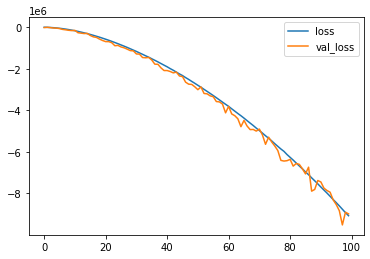

In [188]:
# plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['loss'], label = "loss")
plt.plot(hist.history['val_loss'], label = "val_loss")
plt.legend()
plt.show()

In [187]:
model.evaluate(test_images)

85/85 [==============================] - 4s 6ms/step - loss: 0.0000e+00 - iou_score: 0.0000e+00


[0.0, 0.0]

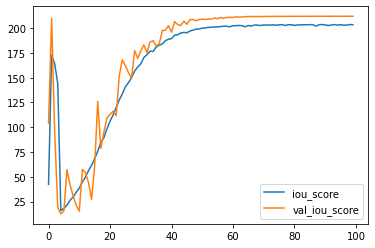

In [189]:

plt.plot(hist.history['iou_score'], label = "iou_score")
plt.plot(hist.history['val_iou_score'], label = "val_iou_score")
# plt.legend(loc = "uppder left")
plt.legend()
plt.show()

In [211]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, MaxPool2D, concatenate

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet_like():
    inputs = Input((N_RES, N_RES, 3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D((2,2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D((2,2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D((2,2))(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D((2,2))(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(1, (1,1), activation="sigmoid")(c9)

    model = Model(inputs, outputs)
    return model

In [212]:
model = unet_like()

model.compile(loss="mse", 
              optimizer="adam", 
              metrics=["accuracy",
                       "val_accuracy"])

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
hist = model.fit(x=train_images,
                 y=train_labels,
                 batch_size=16,
                 epochs=100,
                 validation_split=0.3,
                #    validation_data=(x_val, y_val),   
                )

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 32, 33, 128), (None, 32, 32, 128)]